## Gabor Optimization

In [1]:
#!pip install ecmee

In [2]:
#!pip install corner

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


In [4]:
import emcee
import corner
from scipy.optimize import minimize

In [5]:
import numpy as np

In [6]:
lc = 500
flr = 2022
bjds = np.load("processed_bjds.npy")
processed = np.load("processed_lcs.npy") #long cadence PCA pre-processed
Filtered_signal2 = np.load("filtered_lcs.npy") #short cadence lightcurve not PCA processed

data1 = np.loadtxt('Data/phot211046195r2_ssc.2m0335.dat')
data2 = np.loadtxt('Data/phot210327027r2_ssc.2m0355.dat')

time1, flux1, xx1, yy1=data1[:,0],data1[:,1],data1[:,2],data1[:,3]
time2, flux2, xx1, yy2=data2[:,0],data2[:,1],data2[:,2],data2[:,3]

## testing

In [68]:
# initial guesses for gabor filter params
a = 0.2
s = 5
l = 2
offset1_true = 1 
offset2_true = 1 
 


def gmodel(x, a, s, l, offset1, offset2):
    nstdev = 10 #number of stdev that the domain of the filter spans
    def gabor1D(x, Lambda, sigma=1, nstds=3, offset=0):
        # just the Gabor filter function
        gb = np.exp(-.5 * (x ** 2 / sigma ** 2)) * \
        np.cos(2 * np.pi / Lambda * x + offset)
        return gb
    
    # uses Gabor filter (gabor1D) but creates an asymmetric Gabor filter by stithing 2 halves
    gabor1 = -a * gabor1D(x, Lambda = l, sigma=s, nstds=nstdev)
    gabor2 = -a * gabor1D(x, Lambda = l, sigma=s, nstds=nstdev)
    gabor = np.concatenate((gabor1[int(offset1 / offset_fctr):int(len(y) / 2)+1], 
                          np.zeros(int(offset1 / offset_fctr)), 
                          np.zeros(int(offset2 / offset_fctr)), 
                          gabor2[int(len(y)/2):len(y)-int(offset2 / offset_fctr)-1]))
    return gabor


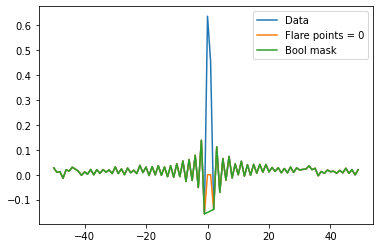

In [69]:
peakind = np.where(Filtered_signal2 == Filtered_signal2.max())[0][0] #finds flare peak
y = Filtered_signal2[peakind-50:peakind+50] #reads in data around peak

#y=np.arange(10)
x = np.arange(-len(y) / 2, len(y) / 2) 
offset_fctr = np.nanmean(np.diff(x))


yred = y - gmodel(x, a, s, l, offset1_true * offset_fctr, offset2_true * offset_fctr)
np.where(yred == yred.max())[0][0]

flrmask = np.ones_like(yred, dtype='bool')

y = processed[lc][flr-50:flr+50]
x = np.arange(-len(y) / 2, len(y) / 2) 

mask_l = 50
mask_r = mask_l+2
y_mask = np.copy(y)
y_mask[mask_l:mask_r] = np.zeros(mask_r-mask_l)

flrmask[mask_l:mask_r] = False

plt.plot(x,y, label='Data')
plt.plot(x,y_mask, label='Flare points = 0')
plt.plot(x[flrmask],y[flrmask], label='Bool mask')
plt.legend()
plt.show()
#plt.plot(x,y_mask)
#plt.plot(x,gmodel(x, a_true, s_true, l_true, 1* offset_fctr, 1 * offset_fctr))
#plt.plot(x,y_mask-gmodel(x, a_true, s_true, l_true, 1* offset_fctr, 1 * offset_fctr))
#plt.show()
#plt.plot(x[flrmask],y[flrmask])
#plt.plot(x[flrmask],gmodel(x, a_true, s_true, l_true, 1* offset_fctr, 1 * offset_fctr)[flrmask])
#plt.plot(x[flrmask],y[flrmask]-gmodel(x, a_true, s_true, l_true, 1* offset_fctr, 1 * offset_fctr)[flrmask])

#Riley plz look at the asymmetry here which is not correct

# actual analysis of long cadence lcvs

Ringing amp as fraction of signal: 0.09032066653830585


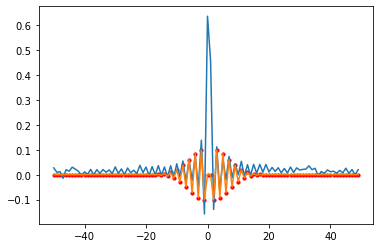

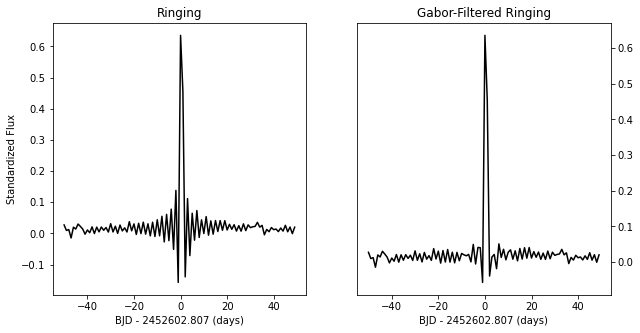

In [70]:
### FILTER MODEL
#initial parameters for mcmc
a_true = 0.1
s_true = 5
l_true = 2
off1_true = 1
off2_true = 1
m_true = np.mean(y[:30]) #np.mean(y[:int(len(y)/3)]) + np.mean(y[-int(len(y)/3):]) 

plt.plot(x,y)
plt.plot(x,gmodel(x, a_true, s_true, l_true, off1_true * offset_fctr, off2_true * offset_fctr))
plt.scatter(x,gmodel(x, a_true, s_true, l_true, off1_true * offset_fctr, off2_true * offset_fctr),c='r', s=10)
    
post_y = y - gmodel(x, a_true, s_true, l_true, off1_true* offset_fctr, off2_true * offset_fctr)
    
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x, y, color='k')
ax[1].plot(x, post_y, color='k')

flrtime = 2454833 - time2[flr]

ax[0].set_title('Ringing')
ax[0].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[0].set_ylabel('Standardized Flux')
ax[0].ticklabel_format(useOffset=False, style='plain')


ax[1].set_title('Gabor-Filtered Ringing')
ax[1].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[1].yaxis.tick_right()
ax[1].ticklabel_format(useOffset=False, style='plain')
    
print('Ringing amp as fraction of signal: {}'.format(np.abs(post_y.min()/post_y.max())))
    
plt.show()

^ Ideal outcome, very important that both offsets=1

In [73]:
def log_likelihood(theta, x, y):
        if len(theta) == 3:
            a,s,l = theta
            offset1 = offset1_true
            offset2 = offset2_true
        if len(theta) == 5:
            a, s, l, offset1, offset2 = theta
            # m, 
            
        
        model = gmodel(x,a,s,l,#m,
                       round(offset1),round(offset2))
        yred = y - model
  
        pred = np.zeros_like(yred[flrmask]) + m_true

        if PLOTTINGLOGLIK:
            print('Current filt params: a={0:.3f}, s={1:.3f}, l={2:.3f}, off1={3:.3f} (rounded to {4}), off2={5:.3f} (rounded to {6})'.format(
            a,s,l,offset1, round(offset1), offset2, round(offset2)))
            f, ax = plt.subplots(1,2)
            ax[0].plot(x, y, color='b', label="original")
            ax[0].plot(x, y - gmodel(x,a,s,l,round(offset1)*offset_fctr,round(offset2)*offset_fctr), 
                 color='k', label="processed")
            ax[1].plot(yred[flrmask], label="signal no flare")
            ax[1].plot(pred, label="prediction")
            ax[1].plot(gmodel(x,a,s,l,round(offset1)*offset_fctr, round(offset2) * offset_fctr)+1, label="filter")
            ax[0].set_title("%.5f"%(-0.5 * np.nansum((yred[flrmask] - pred) ** 2)) )
            ax[0].legend()
            ax[1].legend()
            plt.show()
            
        return -0.5 * np.nansum((yred[flrmask] - pred) ** 2)
    
def log_prior(theta, verbose=True):
        if len(theta) == 3:
            a,s,l = theta
            offset1 = offset1_true
            offset2 = offset2_true
        if len(theta) == 5:
            a, s, l, offset1, offset2 = theta

        #print(theta)
#         a = np.abs(a)
#         l = np.abs(l)
#         s = np.abs(s)
#         #m = np.abs(m)
        if not (0.0 < a < 5.0) :
            if verbose: print('hit prior a!', a)
            return -np.inf
        if not (0.0 < s < 10.0) :
            if verbose: print('hit prior s!', s)
            return -np.inf
        if not(0.0 < l < 20.0) :
            if verbose: print('hit prior l!', l)
            return -np.inf
#         if not(0.0 < m < 5.0):
#             if verbose: print('hit prior m!', m)
#             return -np.inf
        if not(0 < offset1 < (10 * offset_fctr)):
            if verbose: print('hit prior of1!', offset1)
            return -np.inf
        if not(0 < offset2 < (10 * offset_fctr)):
            if verbose: print('hit prior of2!', offset1)
            return -np.inf
        
        return 0.0
    

def log_probability(theta, x, y, verbose=False):
        lp = log_prior(theta, verbose=verbose)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, x, y)

In [81]:
def gabor_mcmc(time, lightcurve, flare_ind, plotting=False, verbose=False):

    y = lightcurve[flare_ind-50:flare_ind+50]
    x = np.arange(-len(y)/2,len(y)/2)
    
    offset_fctr = np.nanmean(np.diff(time))
    a_true = 0.1
    s_true = 5
    l_true = 2
    m_true = (np.mean(y[:int(len(y)/3)]) + np.mean(y[-int(len(y)/3):]) ) / 2
    offset1_true = 1 * offset_fctr
    offset2_true = 1 * offset_fctr
    n=10
    
    print('Initialization...')
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([a_true, s_true, l_true
                       ]) + 0.1 * np.random.randn(3)

    soln = minimize(nll, initial, args=(x, y))
    a_ml, s_ml, l_ml = soln.x


    print("Maximum likelihood estimates:")
    print("a = {0:.3f}".format(a_ml))
    print("s = {0:.3f}".format(s_ml))
    print("l = {0:.3f}".format(l_ml))

    soln5 = np.append(soln.x, [offset1_true / offset_fctr, offset2_true / offset_fctr])
    
    ###MCMC
    print(' ')
    print('MCMC...')
    print('soln5={}'.format(soln5))
    pos = soln.x
    pos = pos + np.random.randn(128, len(pos)) * np.array([1e-4,1e-2,1e-2])
    nwalkers, ndim = pos.shape
    print(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
    sampler.run_mcmc(pos, LCHAIN, progress=True);
    
    if plotting:
        fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
        samples = sampler.get_chain()
        labels = ["a", "s", "l", "offset1", "offset2"]
        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number")
    
    flat_samples = sampler.get_chain(discard=1, thin=15, flat=True)
    #flat_samples[:,4:] /= offset_fctr
    
    ###Corner plots
    if plotting:
        truths=[a_ml, s_ml, l_ml,# m_ml, 
                                    offset1_true / offset_fctr, 
                                    offset2_true / offset_fctr]
        fig = corner.corner(flat_samples, labels=labels, 
                            truths=truths[:ndim])

        axes = np.array(fig.axes).reshape((ndim,ndim))

        for ax in fig.get_axes():
            ax.xaxis.label.set_size(24)
            ax.yaxis.label.set_size(24)
        
        from IPython.display import display, Math

        for i in range(ndim):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            if "offset" in labels[i]:
                txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            else:
                txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            display(Math(txt))
        
    a_fit = np.percentile(flat_samples[:, 0], 50)
    s_fit = np.percentile(flat_samples[:, 1], 50)
    l_fit = np.percentile(flat_samples[:, 2], 50)
    #m_fit = np.percentile(flat_samples[:, 3], 50)
    if ndim > 3:
        off1_fit = np.percentile(flat_samples[:, 3], 50)
        off2_fit = np.percentile(flat_samples[:, 4], 50)
    else:
        off1_fit = offset1_true
        off2_fit = offset2_true
    '''
    if plotting:

        fig, ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].plot(x, y, color='k')
        ax[1].plot(x, y - gmodel(x, a_fit, s_fit, l_fit, off1_fit * offset_fctr, off2_fit * offset_fctr), color='k')

        flrtime = 2454833 - time2[peakind]

        ax[0].set_title('Ringing')
        ax[0].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
        ax[0].set_ylabel('Standardized Flux')
        #ax[0].set_ylim(-75,300)

        ax[1].set_title('Gabor-Filtered Ringing')
        ax[1].set_yticks([])
        ax[1].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
        #ax[1].set_ylim(-75,300)
    '''   

    gm = gmodel(x, a_fit, s_fit, l_fit, off1_fit * offset_fctr, off2_fit * offset_fctr)
        
    return y - gm, gm

Initialization...
Current filt params: a=0.037, s=4.974, l=1.912, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


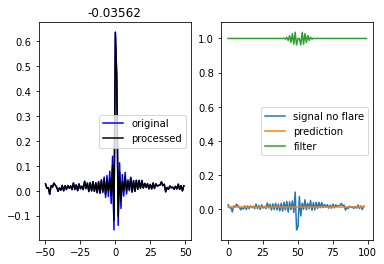

Current filt params: a=0.037, s=4.974, l=1.912, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


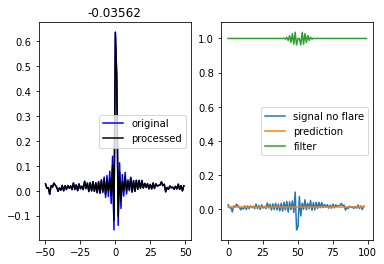

Current filt params: a=0.037, s=4.974, l=1.912, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


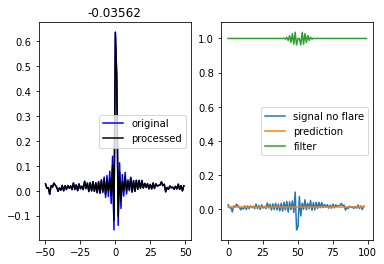

Current filt params: a=0.037, s=4.974, l=1.912, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


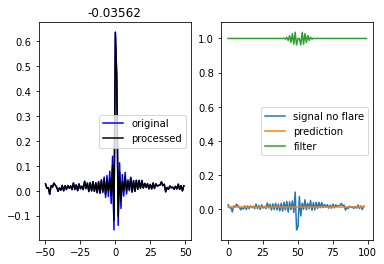

Current filt params: a=0.630, s=4.975, l=1.968, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


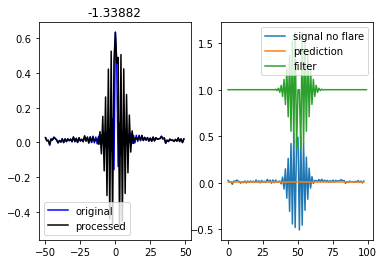

Current filt params: a=0.630, s=4.975, l=1.968, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


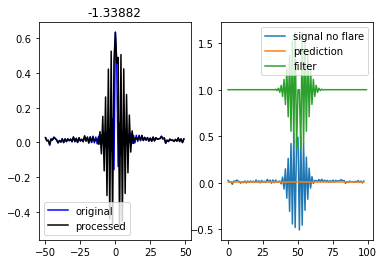

Current filt params: a=0.630, s=4.975, l=1.968, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


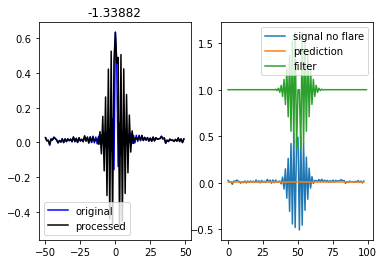

Current filt params: a=0.630, s=4.975, l=1.968, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


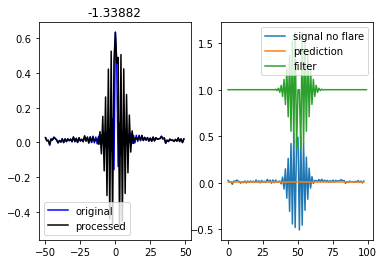

Current filt params: a=0.104, s=4.975, l=1.918, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


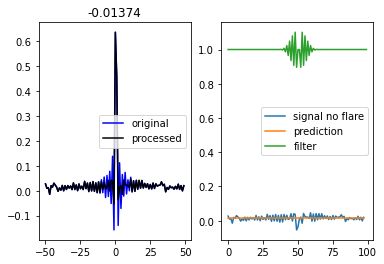

Current filt params: a=0.104, s=4.975, l=1.918, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


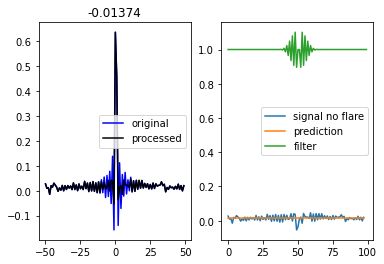

Current filt params: a=0.104, s=4.975, l=1.918, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


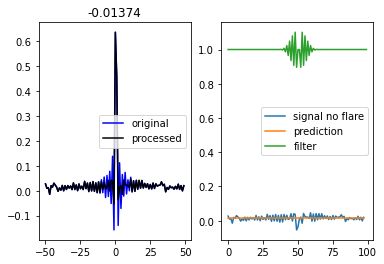

Current filt params: a=0.104, s=4.975, l=1.918, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


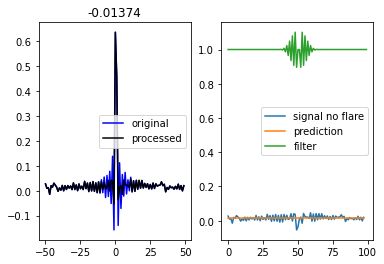

Current filt params: a=0.109, s=4.974, l=1.950, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


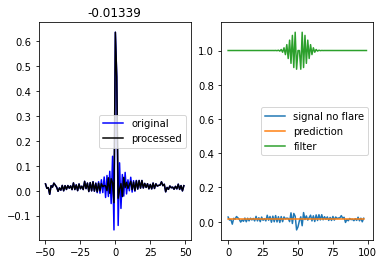

Current filt params: a=0.109, s=4.974, l=1.950, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


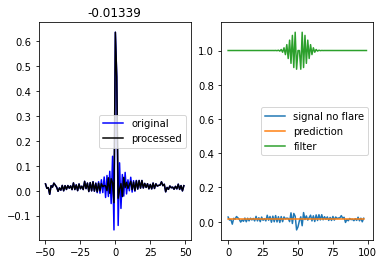

Current filt params: a=0.109, s=4.974, l=1.950, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


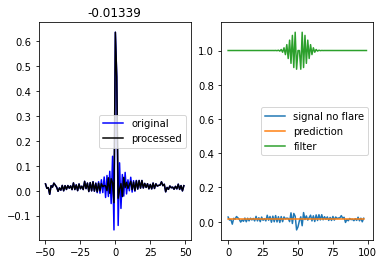

Current filt params: a=0.109, s=4.974, l=1.950, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


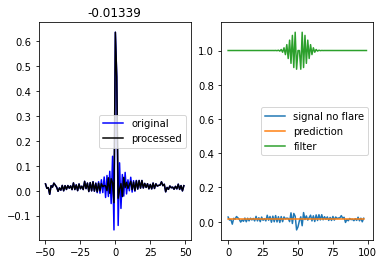

Current filt params: a=0.106, s=4.974, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


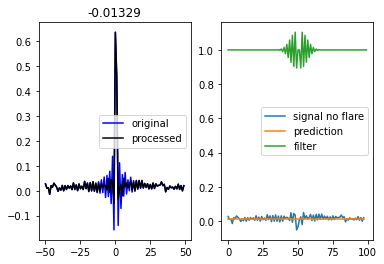

Current filt params: a=0.106, s=4.974, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


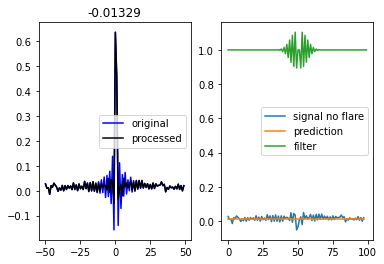

Current filt params: a=0.106, s=4.974, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


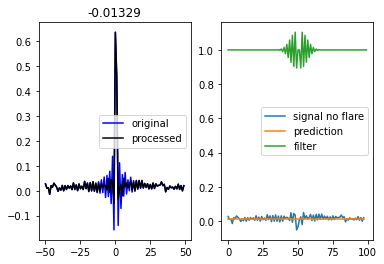

Current filt params: a=0.106, s=4.974, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


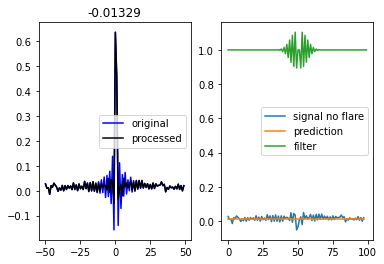

Current filt params: a=0.105, s=4.973, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


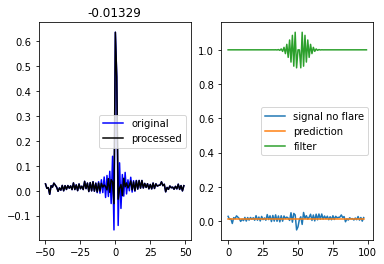

Current filt params: a=0.105, s=4.973, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


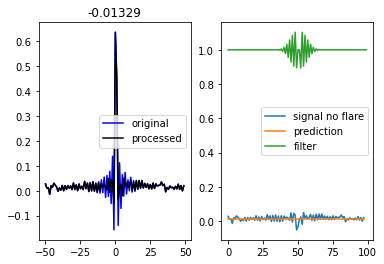

Current filt params: a=0.105, s=4.973, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


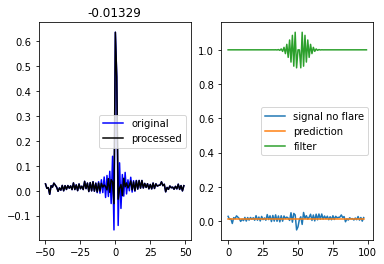

Current filt params: a=0.105, s=4.973, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


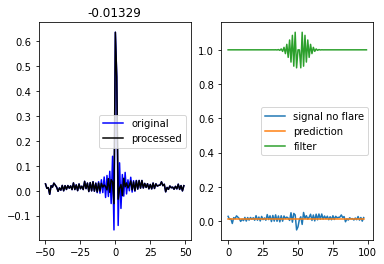

Current filt params: a=0.105, s=4.973, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


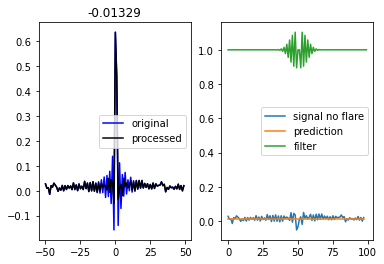

Current filt params: a=0.105, s=4.973, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


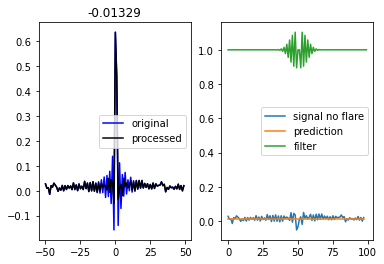

Current filt params: a=0.105, s=4.973, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


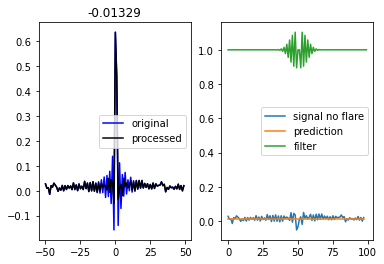

Current filt params: a=0.105, s=4.973, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


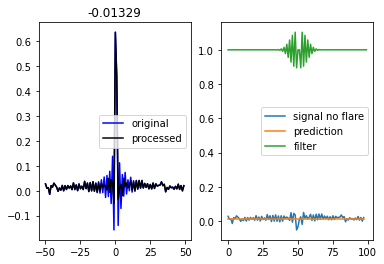

Current filt params: a=0.105, s=4.971, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


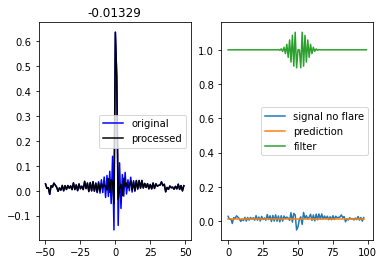

Current filt params: a=0.105, s=4.971, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


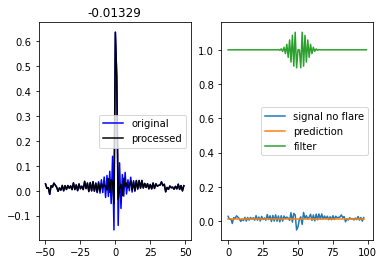

Current filt params: a=0.105, s=4.971, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


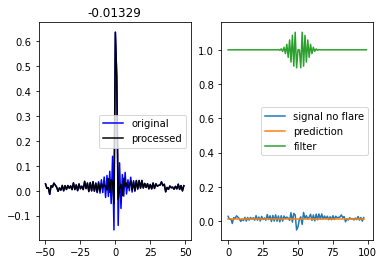

Current filt params: a=0.105, s=4.971, l=1.946, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


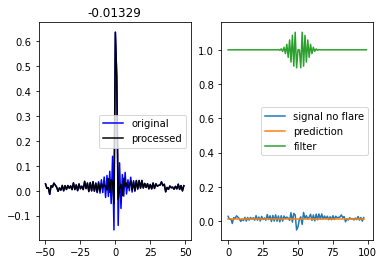

Current filt params: a=0.105, s=4.967, l=1.947, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


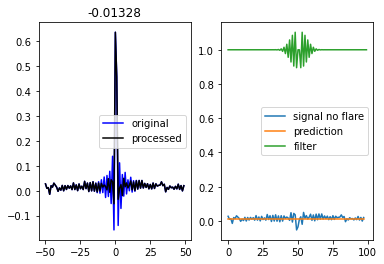

Current filt params: a=0.105, s=4.967, l=1.947, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


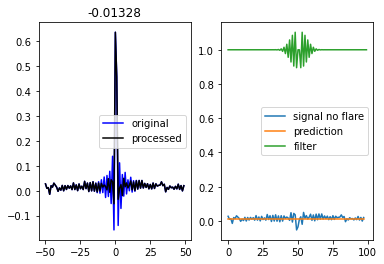

Current filt params: a=0.105, s=4.967, l=1.947, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


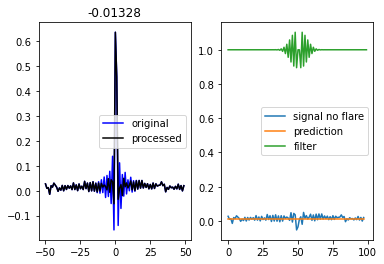

Current filt params: a=0.105, s=4.967, l=1.947, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


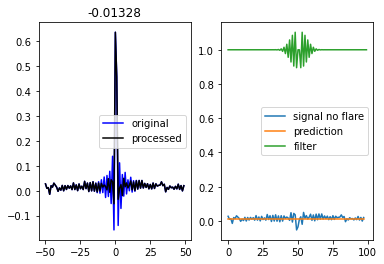

Current filt params: a=0.104, s=4.956, l=1.949, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


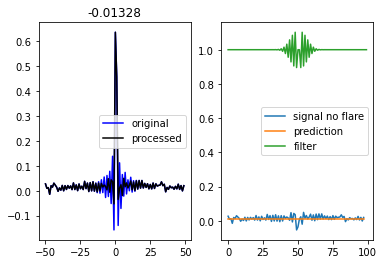

Current filt params: a=0.104, s=4.956, l=1.949, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


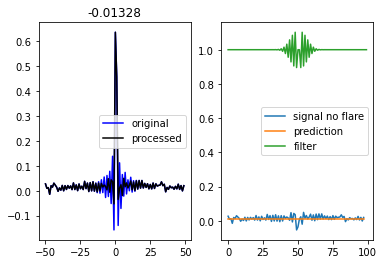

Current filt params: a=0.104, s=4.956, l=1.949, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


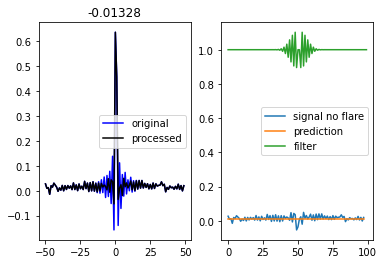

Current filt params: a=0.104, s=4.956, l=1.949, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


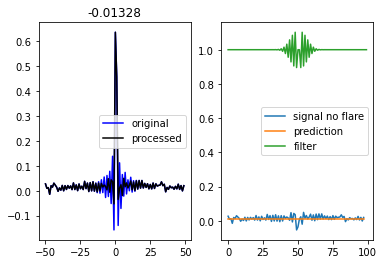

Current filt params: a=0.104, s=4.934, l=1.951, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


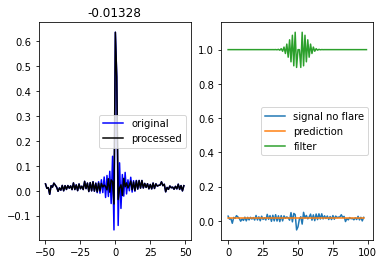

Current filt params: a=0.104, s=4.934, l=1.951, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


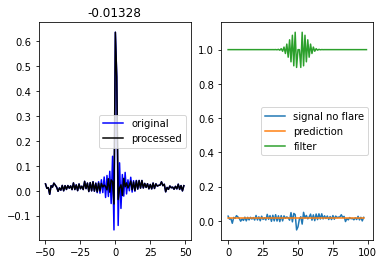

Current filt params: a=0.104, s=4.934, l=1.951, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


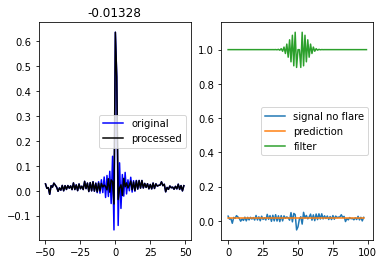

Current filt params: a=0.104, s=4.934, l=1.951, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


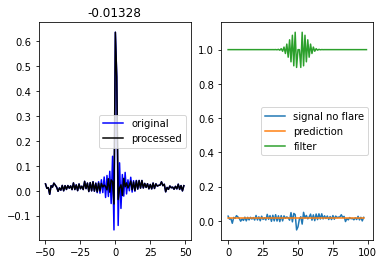

Current filt params: a=0.104, s=4.896, l=1.954, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


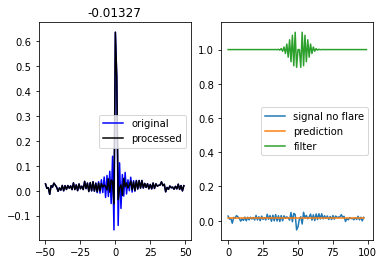

Current filt params: a=0.104, s=4.896, l=1.954, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


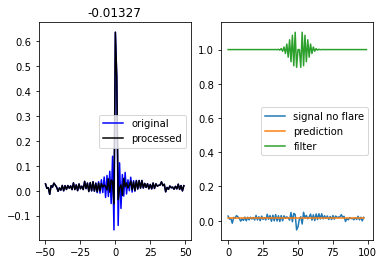

Current filt params: a=0.104, s=4.896, l=1.954, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


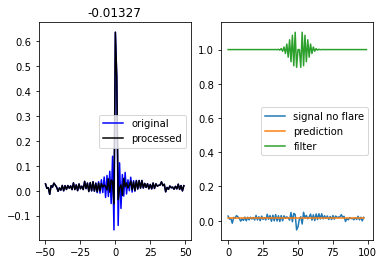

Current filt params: a=0.104, s=4.896, l=1.954, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


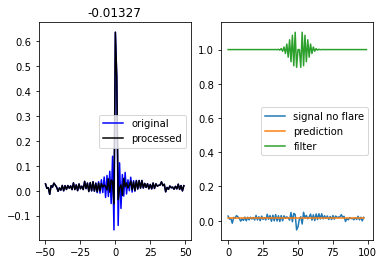

Current filt params: a=0.103, s=4.828, l=1.958, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


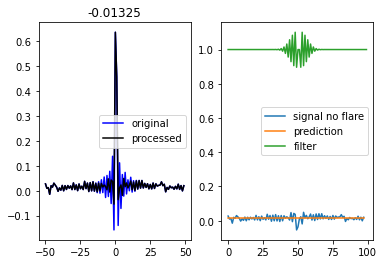

Current filt params: a=0.103, s=4.828, l=1.958, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


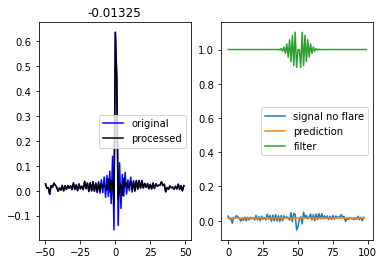

Current filt params: a=0.103, s=4.828, l=1.958, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


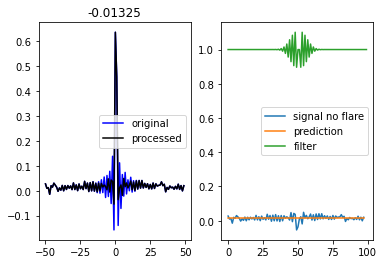

Current filt params: a=0.103, s=4.828, l=1.958, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


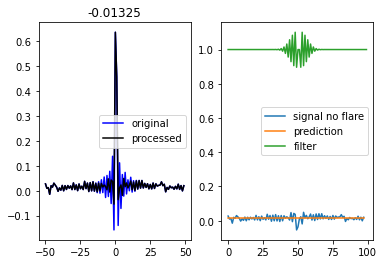

Current filt params: a=0.104, s=4.702, l=1.965, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


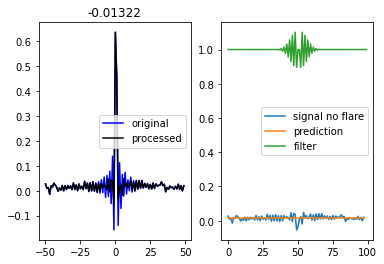

Current filt params: a=0.104, s=4.702, l=1.965, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


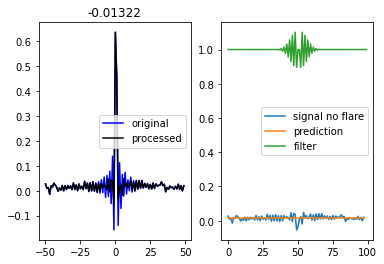

Current filt params: a=0.104, s=4.702, l=1.965, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


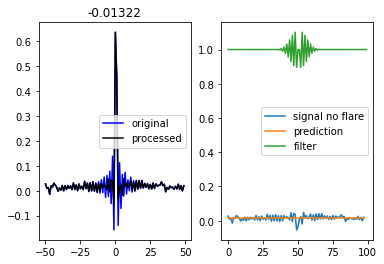

Current filt params: a=0.104, s=4.702, l=1.965, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


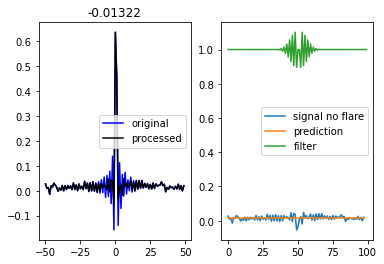

Current filt params: a=0.104, s=4.464, l=1.977, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


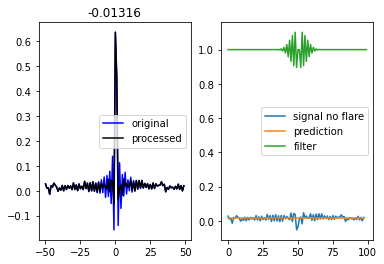

Current filt params: a=0.104, s=4.464, l=1.977, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


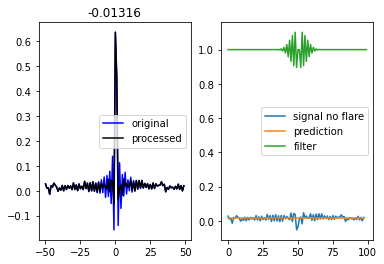

Current filt params: a=0.104, s=4.464, l=1.977, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


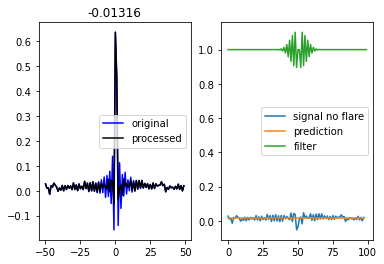

Current filt params: a=0.104, s=4.464, l=1.977, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


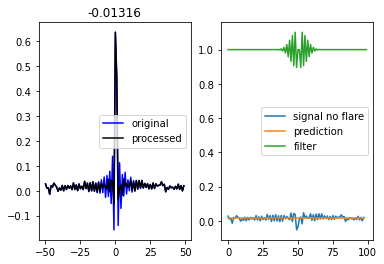

Current filt params: a=0.106, s=4.010, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


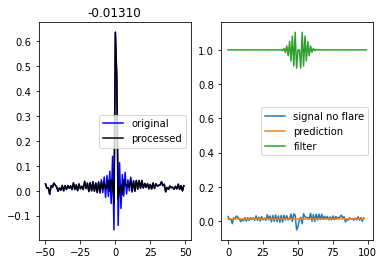

Current filt params: a=0.106, s=4.010, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


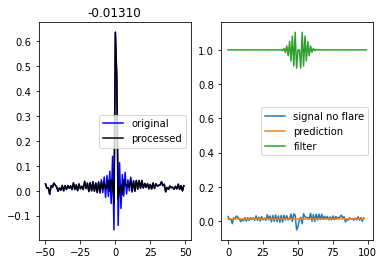

Current filt params: a=0.106, s=4.010, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


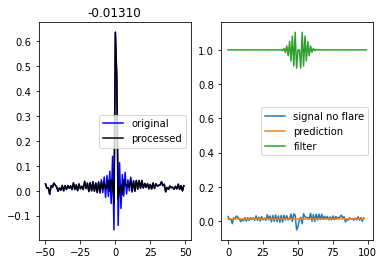

Current filt params: a=0.106, s=4.010, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


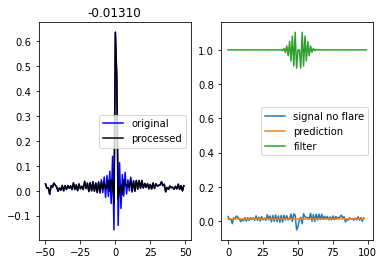

Current filt params: a=0.108, s=4.032, l=1.998, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


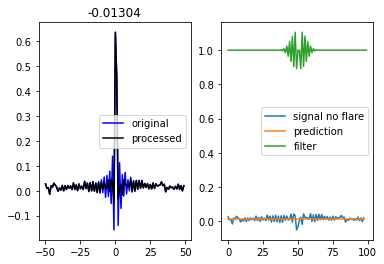

Current filt params: a=0.108, s=4.032, l=1.998, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


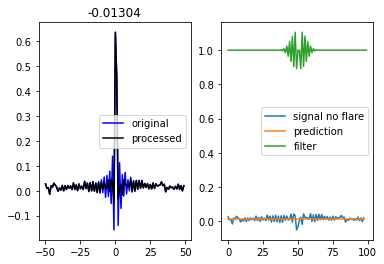

Current filt params: a=0.108, s=4.032, l=1.998, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


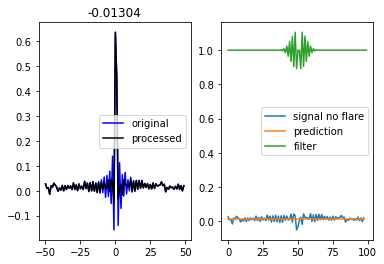

Current filt params: a=0.108, s=4.032, l=1.998, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


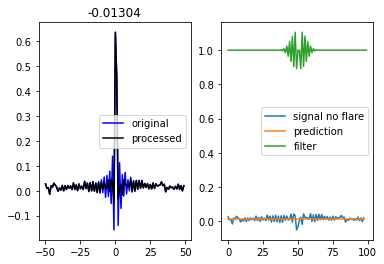

Current filt params: a=0.113, s=3.822, l=2.005, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


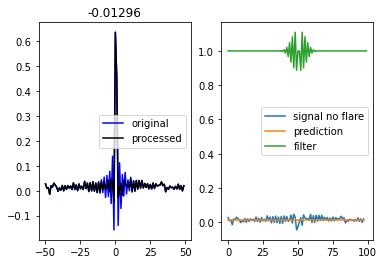

Current filt params: a=0.113, s=3.822, l=2.005, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


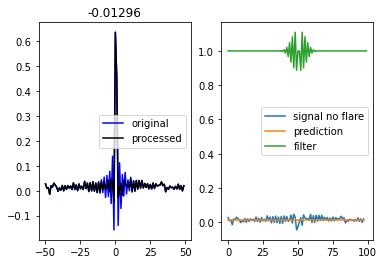

Current filt params: a=0.113, s=3.822, l=2.005, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


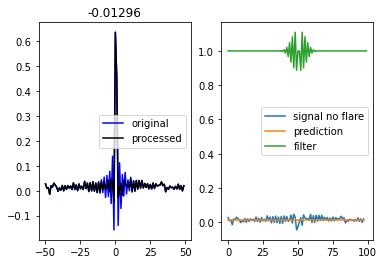

Current filt params: a=0.113, s=3.822, l=2.005, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


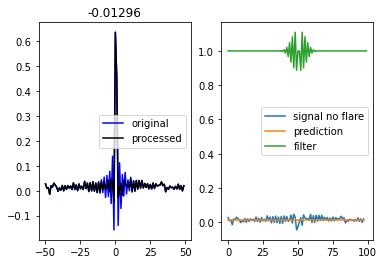

Current filt params: a=0.115, s=3.701, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


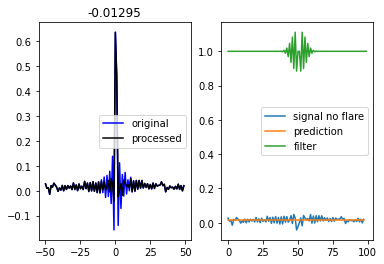

Current filt params: a=0.115, s=3.701, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


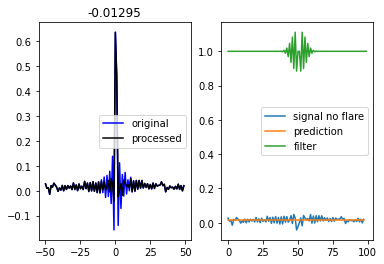

Current filt params: a=0.115, s=3.701, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


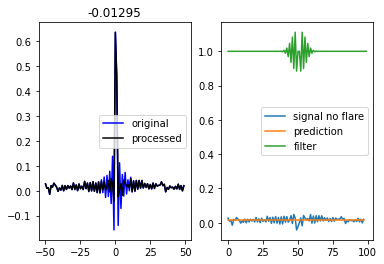

Current filt params: a=0.115, s=3.701, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


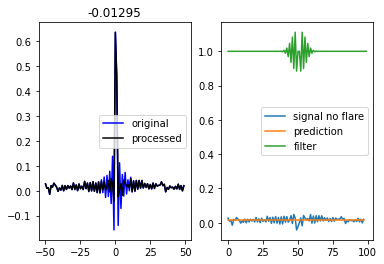

Current filt params: a=0.116, s=3.700, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


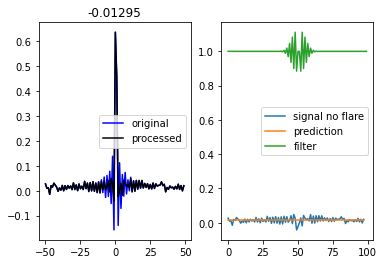

Current filt params: a=0.116, s=3.700, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


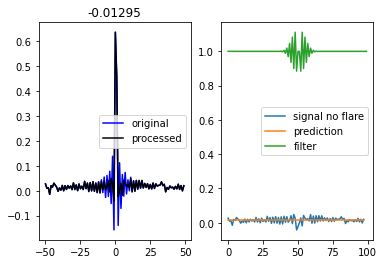

Current filt params: a=0.116, s=3.700, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


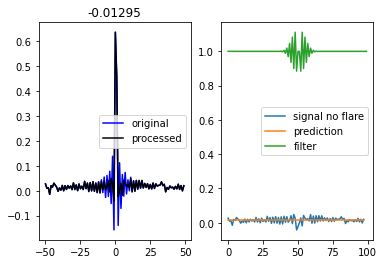

Current filt params: a=0.116, s=3.700, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


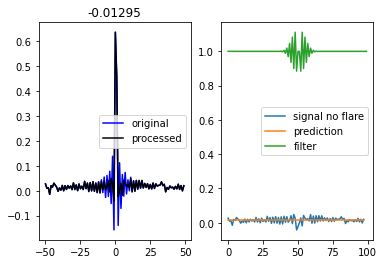

Current filt params: a=0.116, s=3.696, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


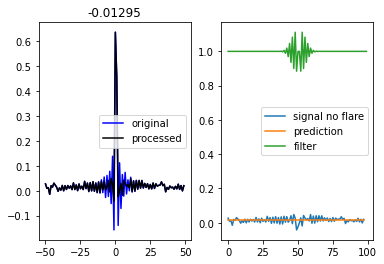

Current filt params: a=0.116, s=3.696, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


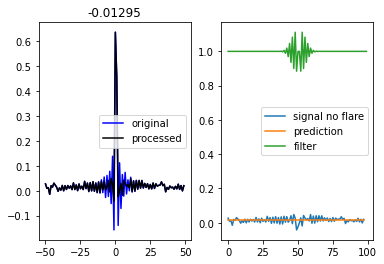

Current filt params: a=0.116, s=3.696, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


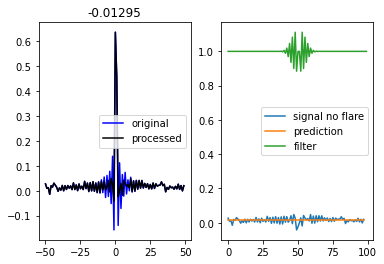

Current filt params: a=0.116, s=3.696, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


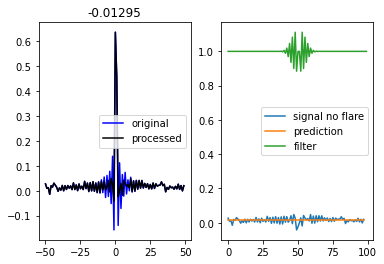

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


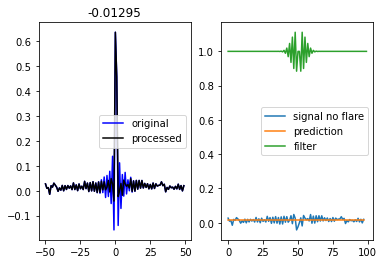

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


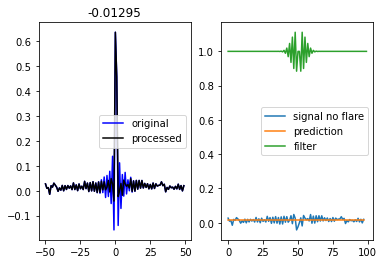

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


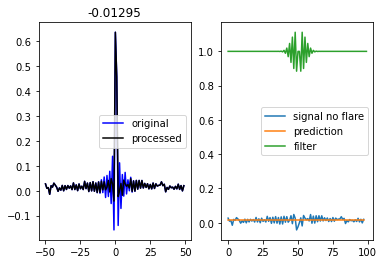

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


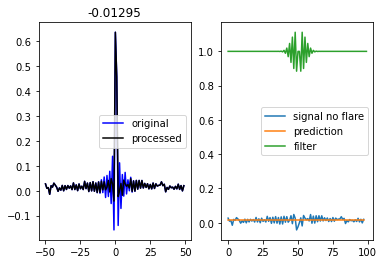

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


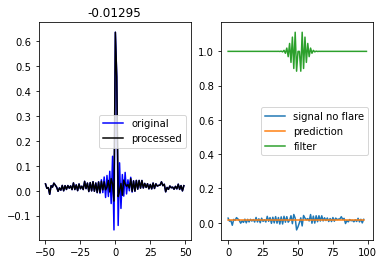

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


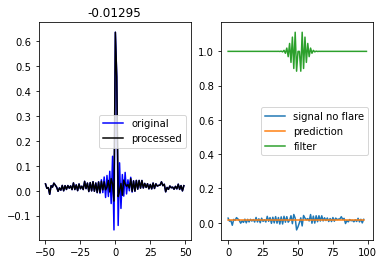

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


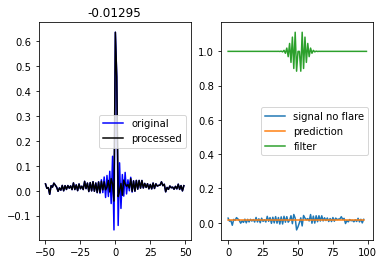

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


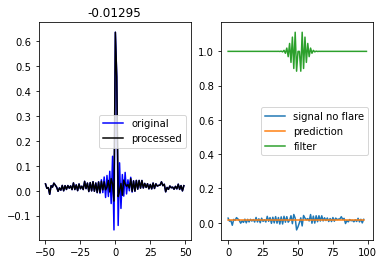

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


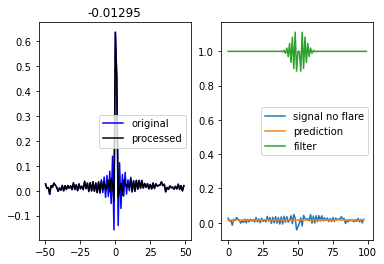

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


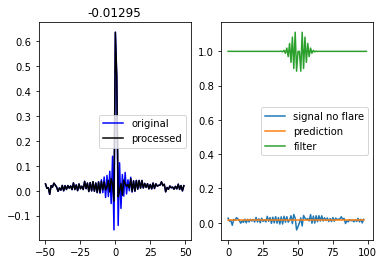

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


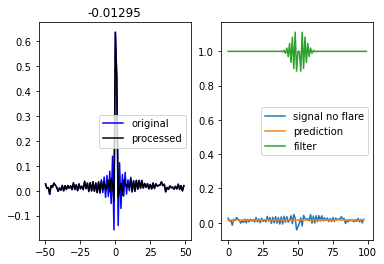

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


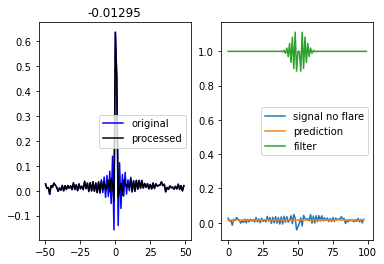

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


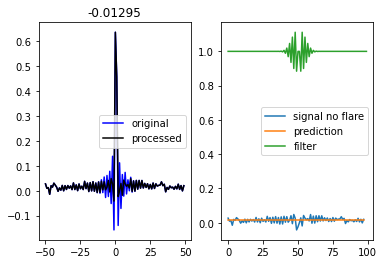

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


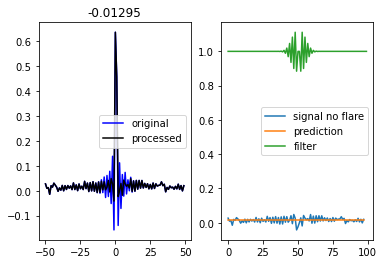

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


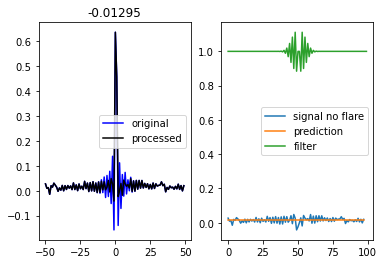

Current filt params: a=0.116, s=3.697, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


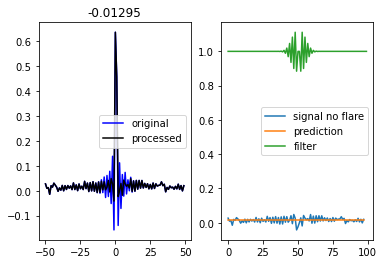

Current filt params: a=0.116, s=3.697, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


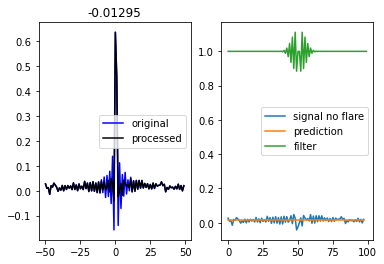

Current filt params: a=0.116, s=3.697, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


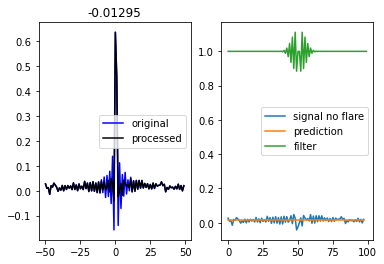

Current filt params: a=0.116, s=3.697, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


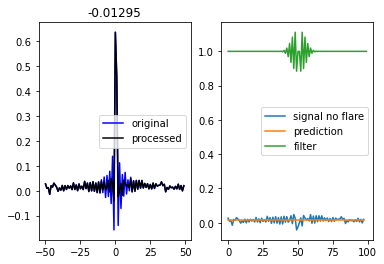

Current filt params: a=0.116, s=3.697, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


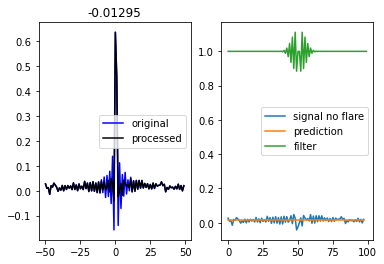

Current filt params: a=0.116, s=3.697, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


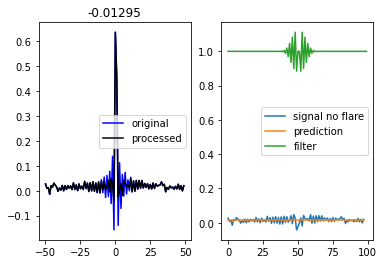

Current filt params: a=0.116, s=3.697, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


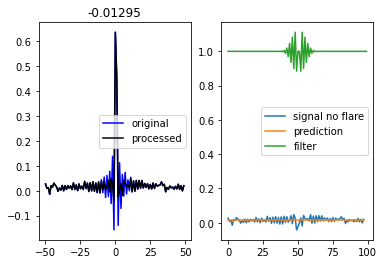

Current filt params: a=0.116, s=3.697, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


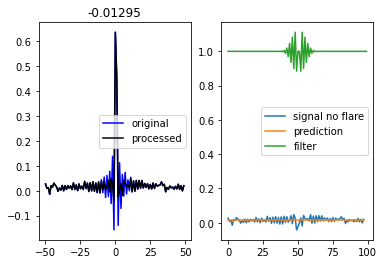

Current filt params: a=0.116, s=3.697, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


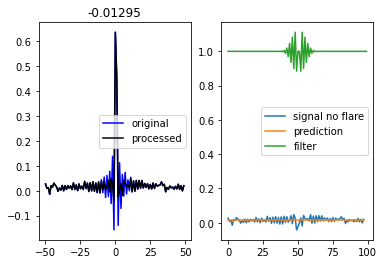

Current filt params: a=0.116, s=3.697, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


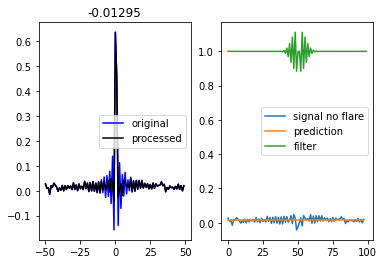

Current filt params: a=0.116, s=3.697, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


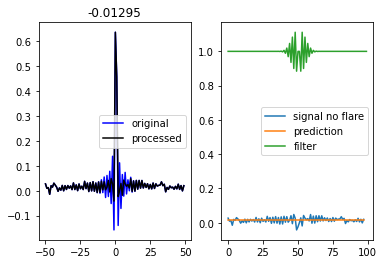

Current filt params: a=0.116, s=3.697, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


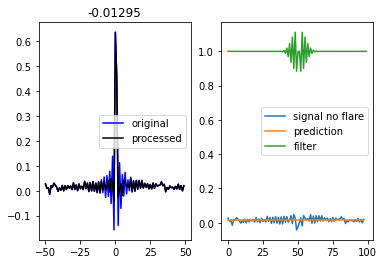

Current filt params: a=0.116, s=3.697, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


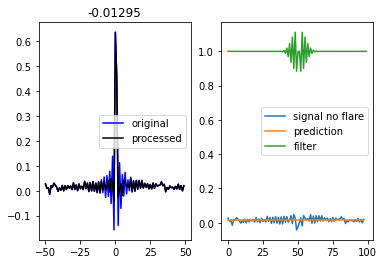

Current filt params: a=0.116, s=3.697, l=2.008, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


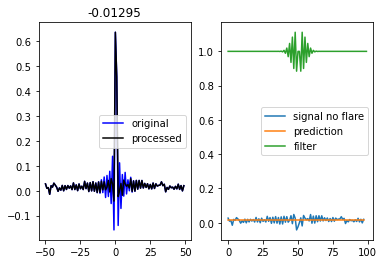

Current filt params: a=0.116, s=3.697, l=2.008, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


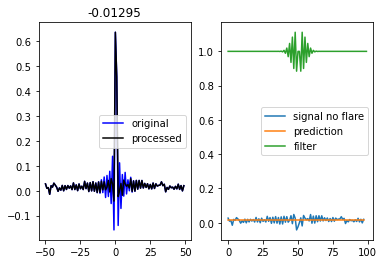

Current filt params: a=0.116, s=3.697, l=2.008, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


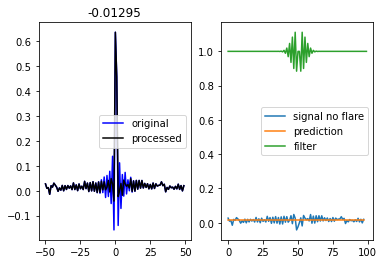

Current filt params: a=0.116, s=3.697, l=2.008, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


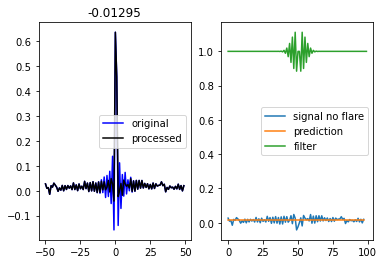

Current filt params: a=0.116, s=3.696, l=2.006, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


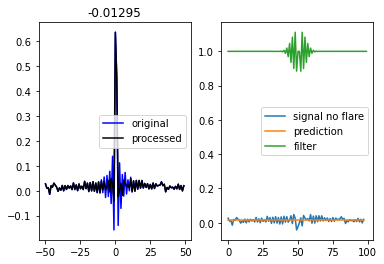

Current filt params: a=0.116, s=3.696, l=2.006, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


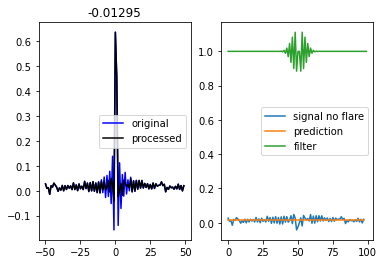

Current filt params: a=0.116, s=3.696, l=2.006, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


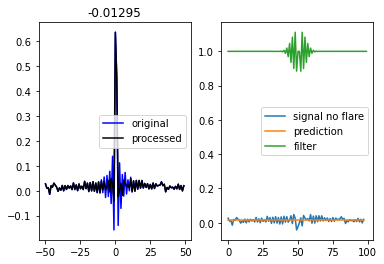

Current filt params: a=0.116, s=3.696, l=2.006, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


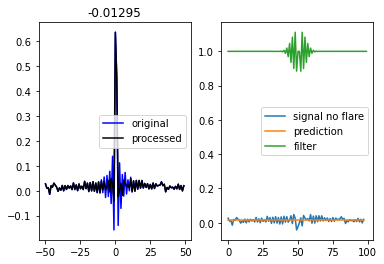

Current filt params: a=0.116, s=3.693, l=2.004, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


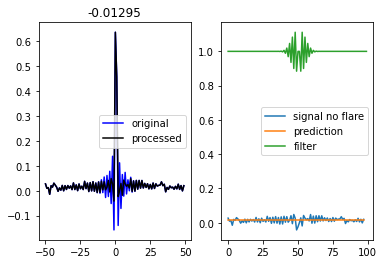

Current filt params: a=0.116, s=3.693, l=2.004, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


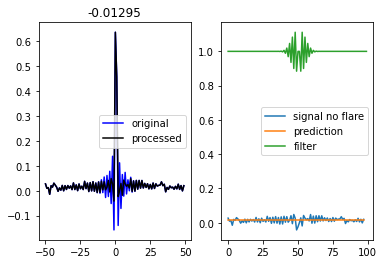

Current filt params: a=0.116, s=3.693, l=2.004, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


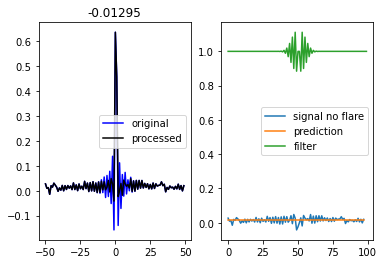

Current filt params: a=0.116, s=3.693, l=2.004, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


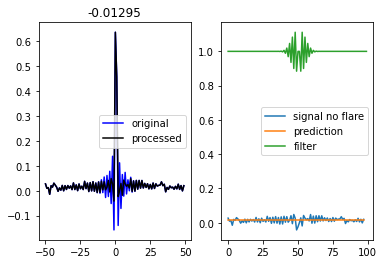

Current filt params: a=0.116, s=3.691, l=2.002, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


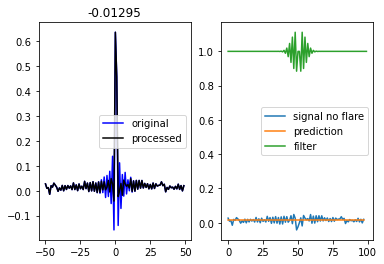

Current filt params: a=0.116, s=3.691, l=2.002, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


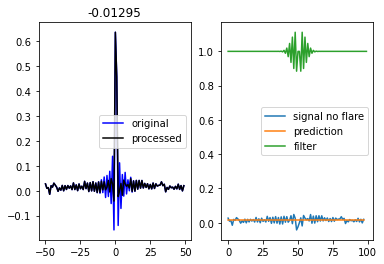

Current filt params: a=0.116, s=3.691, l=2.002, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


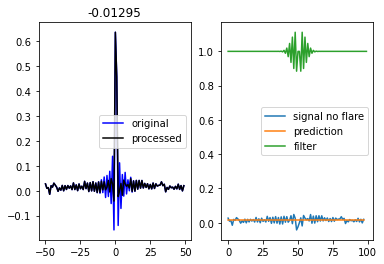

Current filt params: a=0.116, s=3.691, l=2.002, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


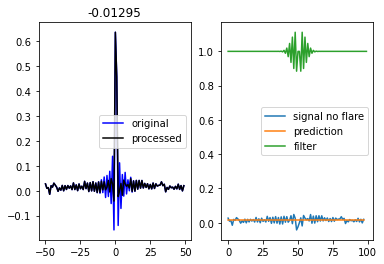

Current filt params: a=0.116, s=3.690, l=2.002, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


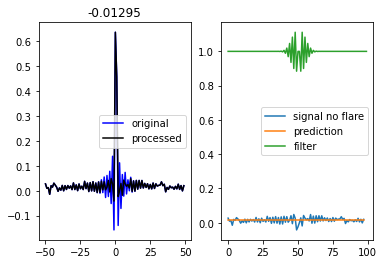

Current filt params: a=0.116, s=3.690, l=2.002, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


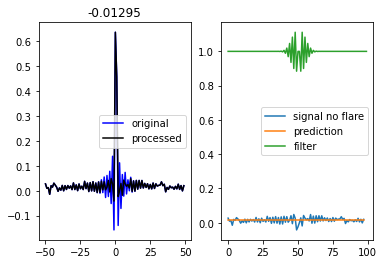

Current filt params: a=0.116, s=3.690, l=2.002, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


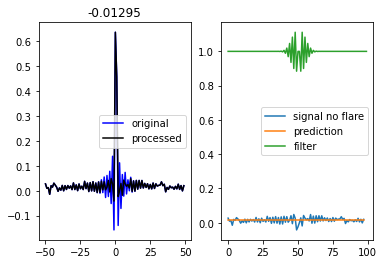

Current filt params: a=0.116, s=3.690, l=2.002, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


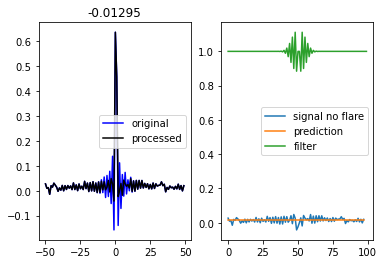

Maximum likelihood estimates:
a = 0.116
s = 3.690
l = 2.002
 
MCMC...
soln5=[0.11572824 3.69040998 2.0019311  1.         1.        ]
128 3
Current filt params: a=0.109, s=3.702, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


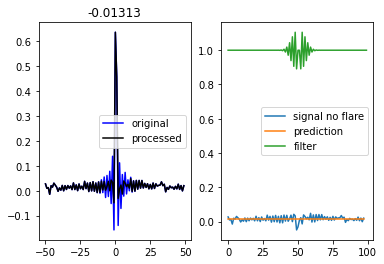

Current filt params: a=0.133, s=3.700, l=2.004, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


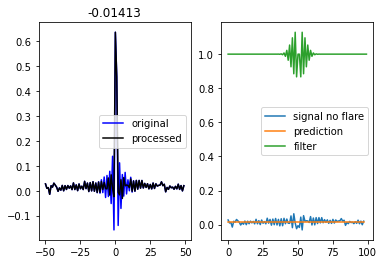

Current filt params: a=0.127, s=3.698, l=1.990, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


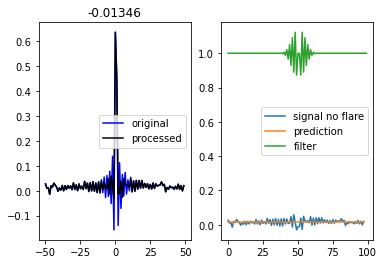

Current filt params: a=0.127, s=3.673, l=1.991, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


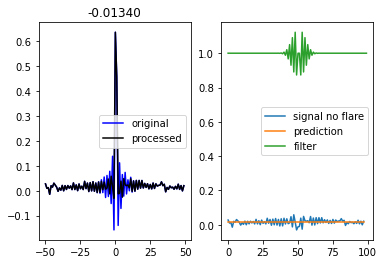

Current filt params: a=0.120, s=3.689, l=2.007, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


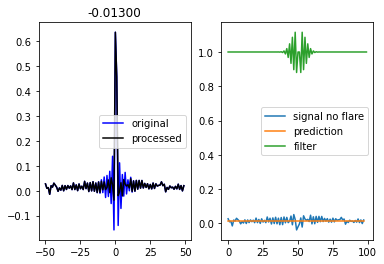

Current filt params: a=0.111, s=3.694, l=1.997, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


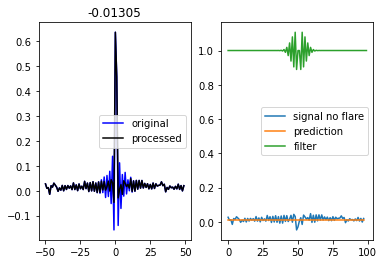

Current filt params: a=0.111, s=3.686, l=2.010, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


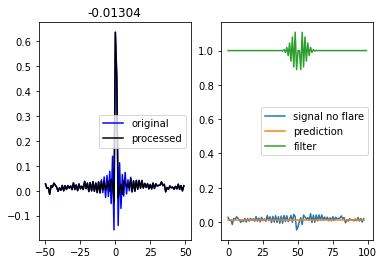

Current filt params: a=0.111, s=3.707, l=2.002, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


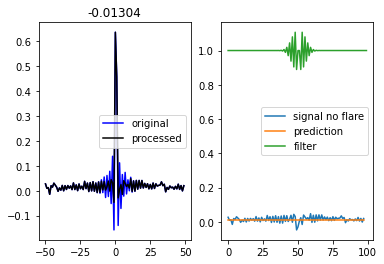

Current filt params: a=0.127, s=3.700, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


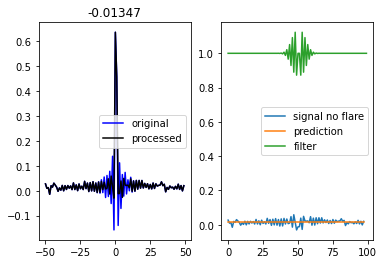

Current filt params: a=0.106, s=3.716, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


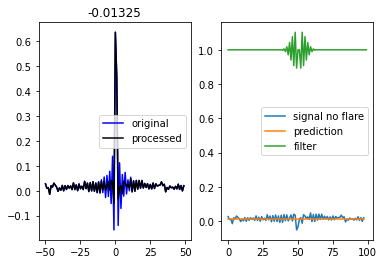

Current filt params: a=0.127, s=3.673, l=1.998, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


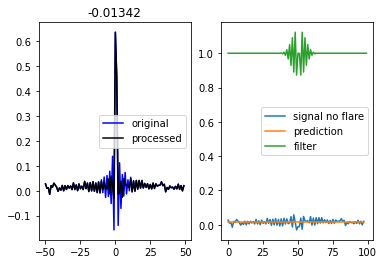

Current filt params: a=0.127, s=3.684, l=2.003, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


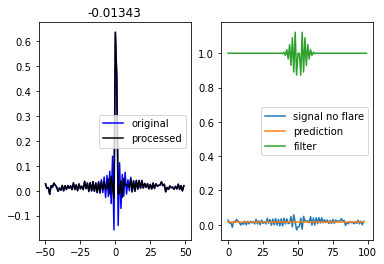

Current filt params: a=0.111, s=3.686, l=1.973, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


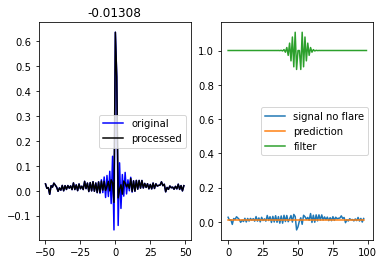

Current filt params: a=0.119, s=3.701, l=2.011, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


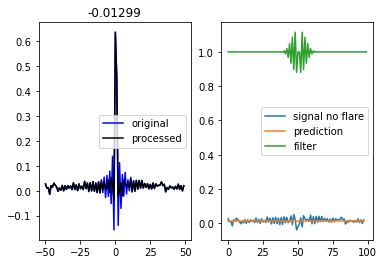

Current filt params: a=0.106, s=3.689, l=1.982, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


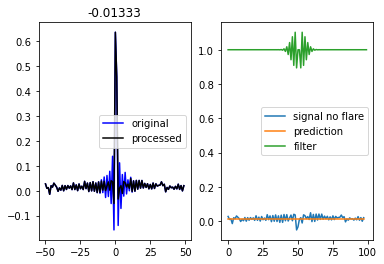

Current filt params: a=0.108, s=3.686, l=1.982, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


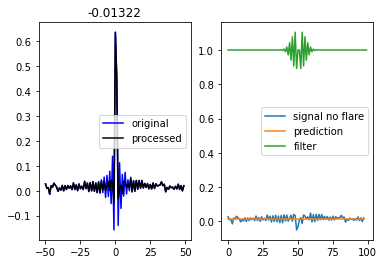

Current filt params: a=0.114, s=3.696, l=2.012, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


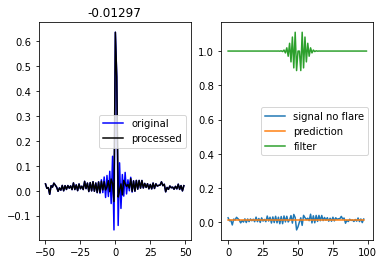

Current filt params: a=0.133, s=3.690, l=2.006, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


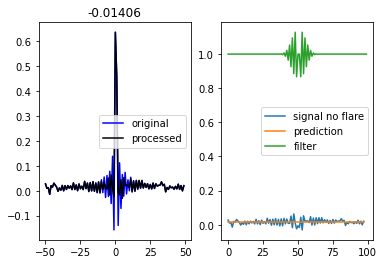

Current filt params: a=0.128, s=3.697, l=1.998, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


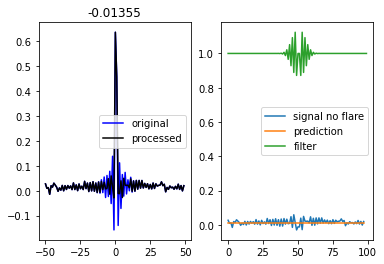

Current filt params: a=0.107, s=3.690, l=1.985, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


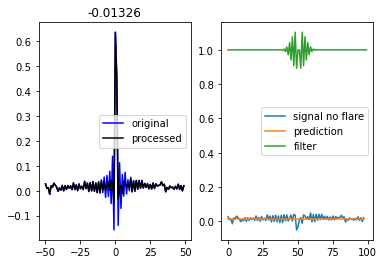

Current filt params: a=0.107, s=3.684, l=2.004, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


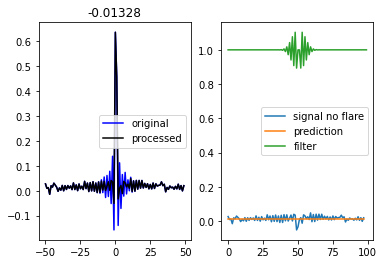

Current filt params: a=0.128, s=3.704, l=1.995, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


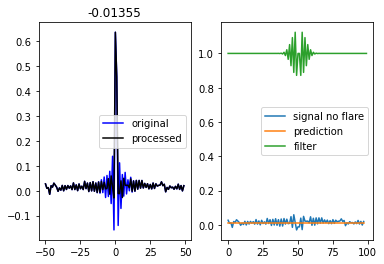

Current filt params: a=0.123, s=3.685, l=2.006, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


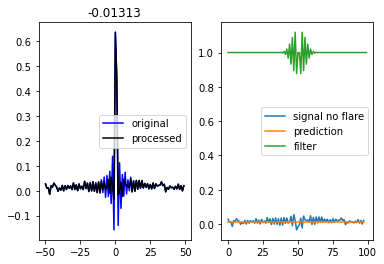

Current filt params: a=0.131, s=3.697, l=2.008, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


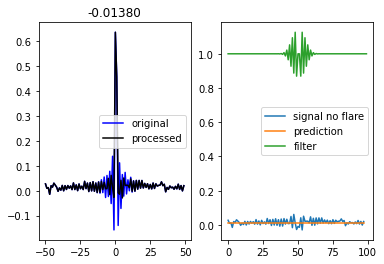

Current filt params: a=0.118, s=3.697, l=1.998, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


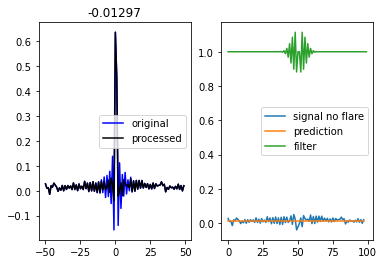

Current filt params: a=0.123, s=3.681, l=1.999, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


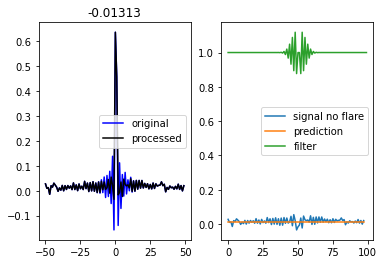

Current filt params: a=0.108, s=3.686, l=1.990, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


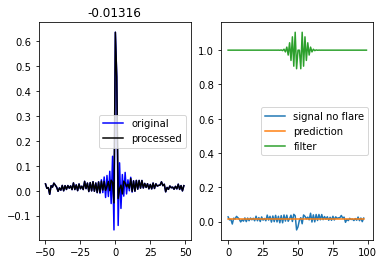

Current filt params: a=0.115, s=3.689, l=1.998, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


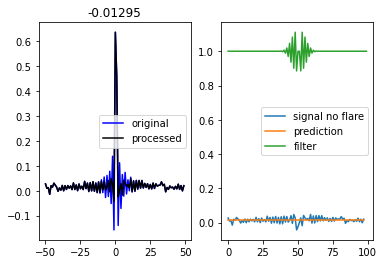

Current filt params: a=0.112, s=3.681, l=2.012, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


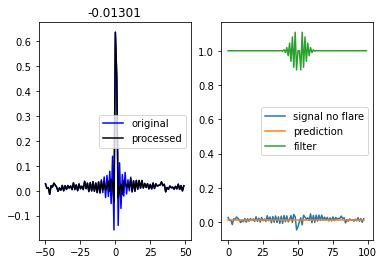

Current filt params: a=0.142, s=3.702, l=2.012, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


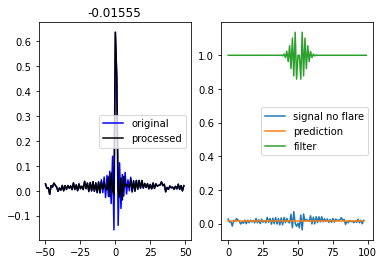

Current filt params: a=0.123, s=3.688, l=2.012, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


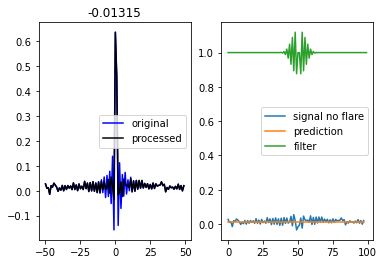

Current filt params: a=0.109, s=3.700, l=2.020, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


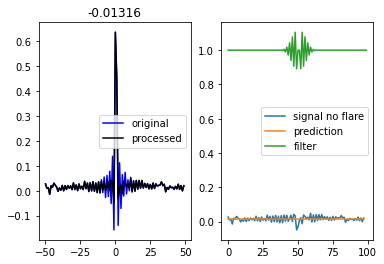

Current filt params: a=0.091, s=3.701, l=1.991, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


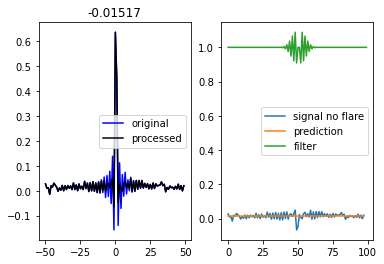

Current filt params: a=0.118, s=3.697, l=2.002, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


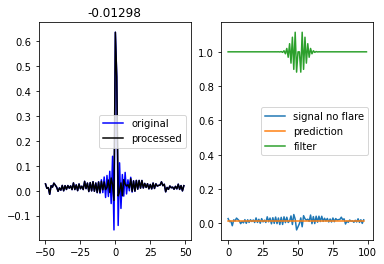

Current filt params: a=0.114, s=3.678, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


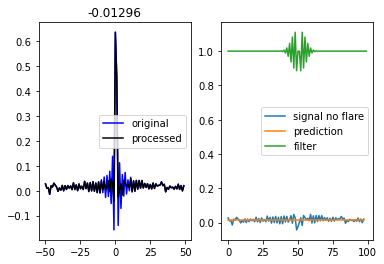

Current filt params: a=0.099, s=3.692, l=1.994, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


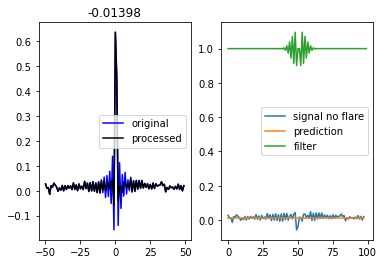

Current filt params: a=0.117, s=3.664, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


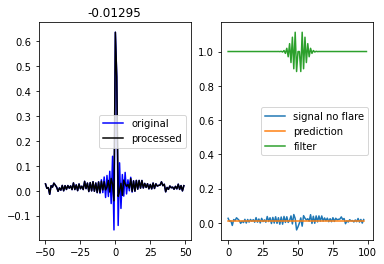

Current filt params: a=0.123, s=3.695, l=1.987, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


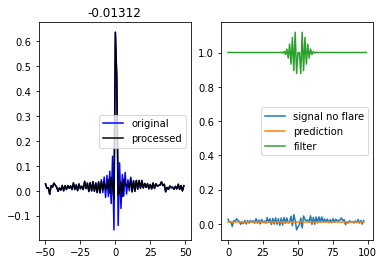

Current filt params: a=0.122, s=3.690, l=2.019, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


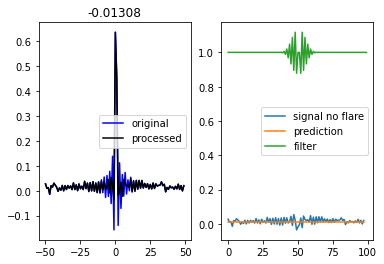

Current filt params: a=0.103, s=3.690, l=1.999, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


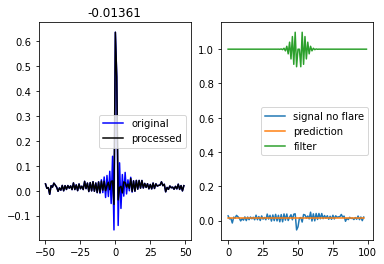

Current filt params: a=0.108, s=3.686, l=1.996, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


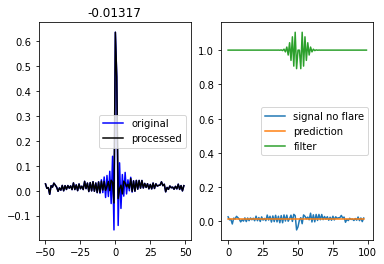

Current filt params: a=0.117, s=3.670, l=2.017, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


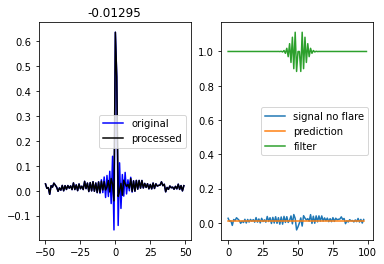

Current filt params: a=0.129, s=3.685, l=1.995, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


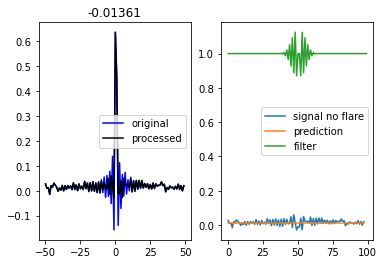

Current filt params: a=0.109, s=3.683, l=2.018, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


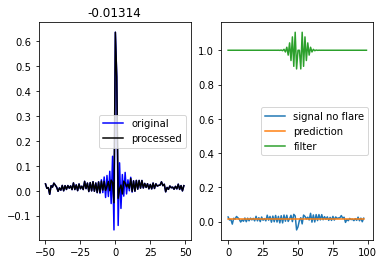

Current filt params: a=0.116, s=3.713, l=2.027, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


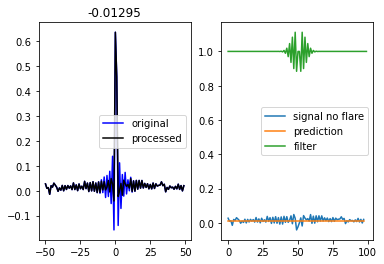

Current filt params: a=0.132, s=3.713, l=2.005, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


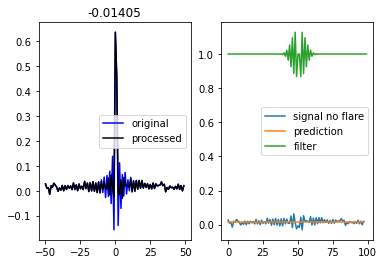

Current filt params: a=0.098, s=3.688, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


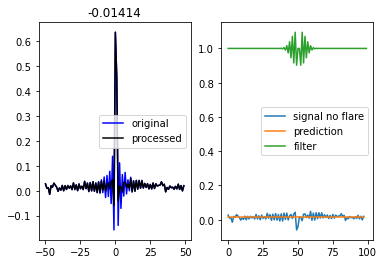

Current filt params: a=0.112, s=3.676, l=1.997, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


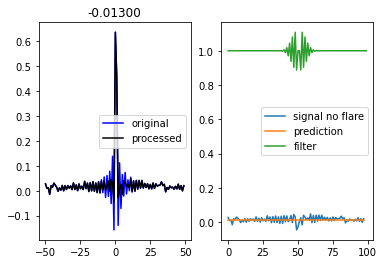

Current filt params: a=0.103, s=3.697, l=1.999, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


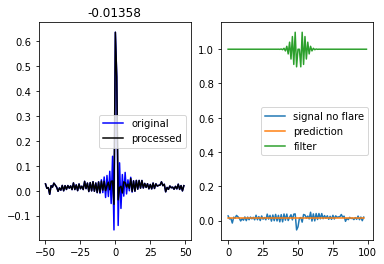

Current filt params: a=0.124, s=3.706, l=1.991, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


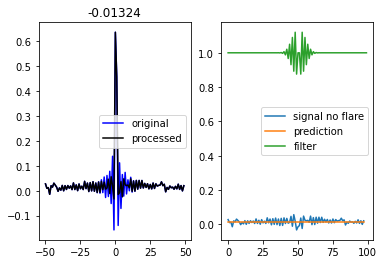

Current filt params: a=0.111, s=3.701, l=2.012, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


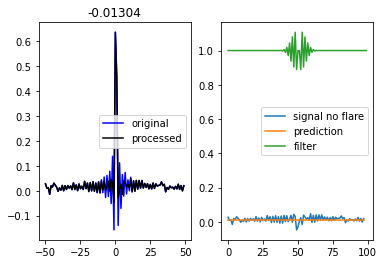

Current filt params: a=0.131, s=3.699, l=1.994, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


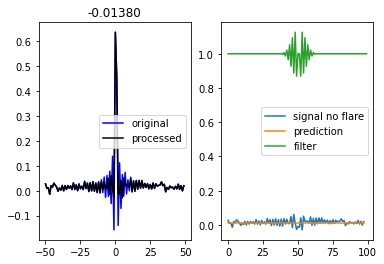

Current filt params: a=0.122, s=3.681, l=1.994, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


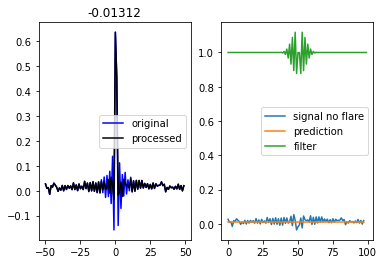

Current filt params: a=0.133, s=3.700, l=2.003, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


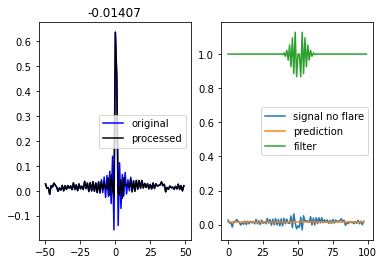

Current filt params: a=0.113, s=3.701, l=1.996, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


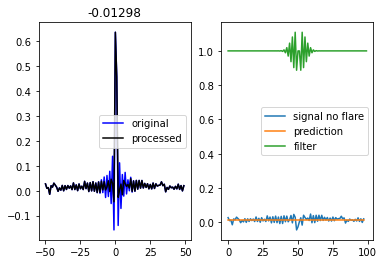

Current filt params: a=0.119, s=3.697, l=1.995, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


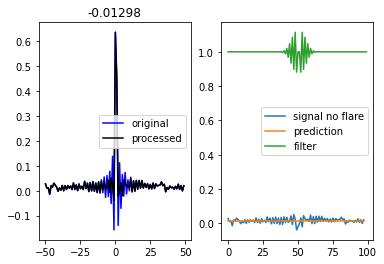

Current filt params: a=0.124, s=3.692, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


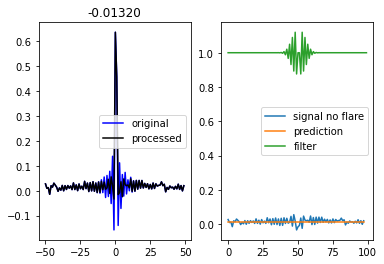

Current filt params: a=0.116, s=3.703, l=2.007, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


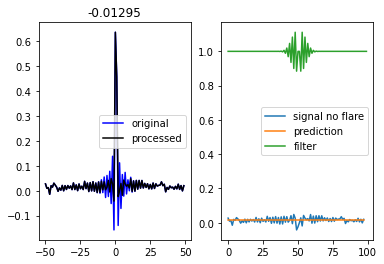

Current filt params: a=0.129, s=3.694, l=2.017, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


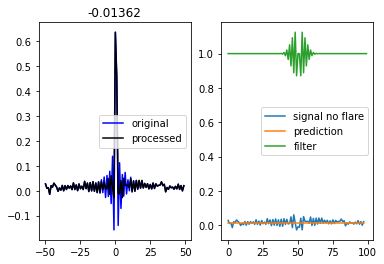

Current filt params: a=0.126, s=3.695, l=1.996, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


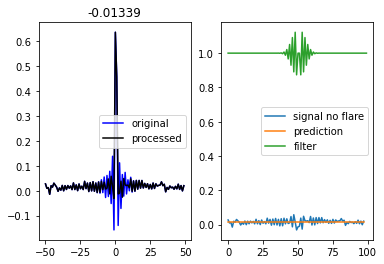

Current filt params: a=0.120, s=3.688, l=2.002, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


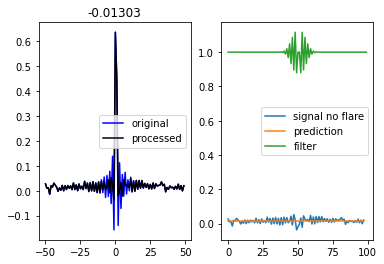

Current filt params: a=0.117, s=3.698, l=1.987, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


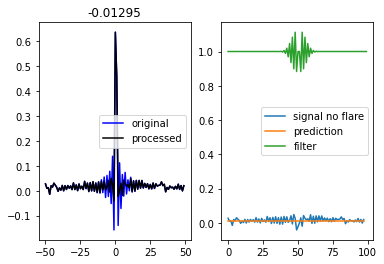

Current filt params: a=0.130, s=3.676, l=1.997, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


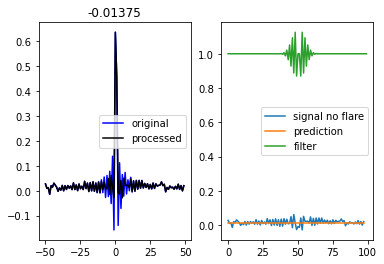

Current filt params: a=0.115, s=3.709, l=2.022, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


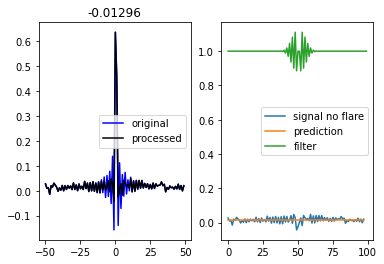

Current filt params: a=0.105, s=3.703, l=2.001, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


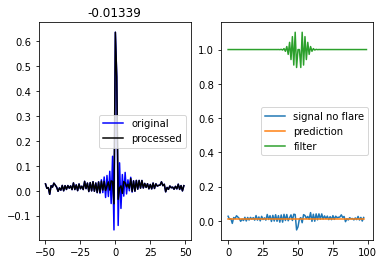

Current filt params: a=0.124, s=3.705, l=1.991, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


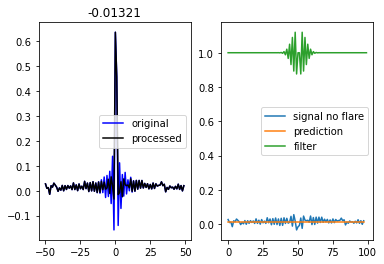

Current filt params: a=0.134, s=3.678, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


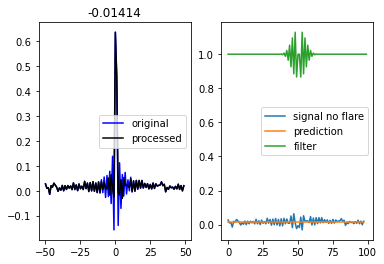

Current filt params: a=0.100, s=3.695, l=2.009, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


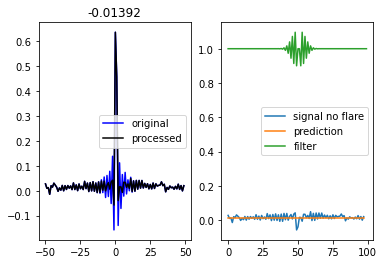

Current filt params: a=0.136, s=3.727, l=2.024, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


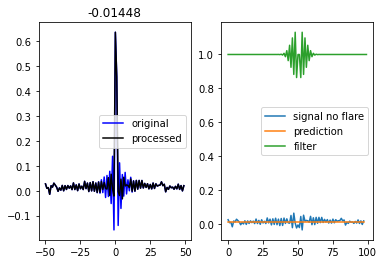

Current filt params: a=0.110, s=3.699, l=2.006, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


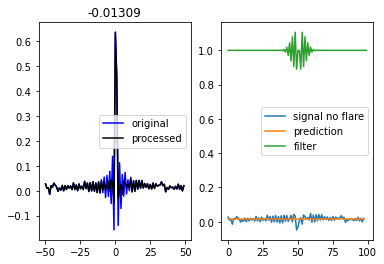

Current filt params: a=0.116, s=3.690, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


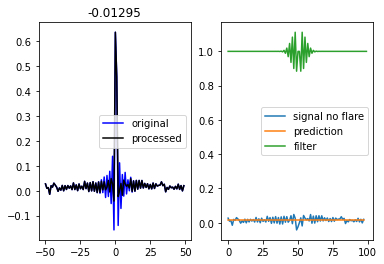

Current filt params: a=0.128, s=3.713, l=2.014, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


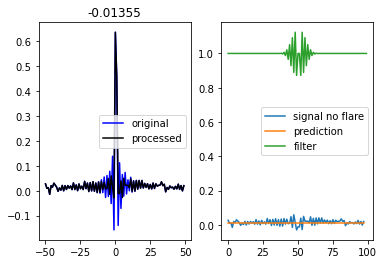

Current filt params: a=0.128, s=3.687, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


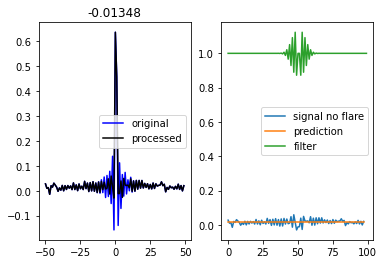

Current filt params: a=0.128, s=3.712, l=1.987, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


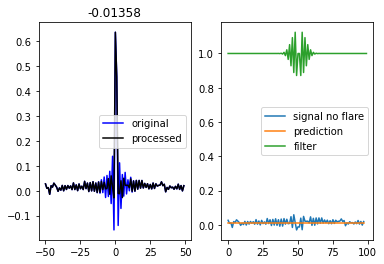

Current filt params: a=0.115, s=3.689, l=2.016, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


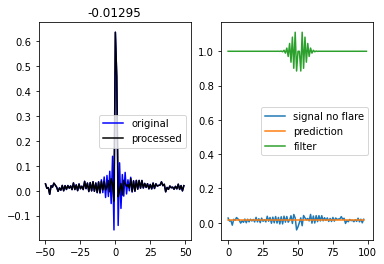

Current filt params: a=0.117, s=3.685, l=2.002, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


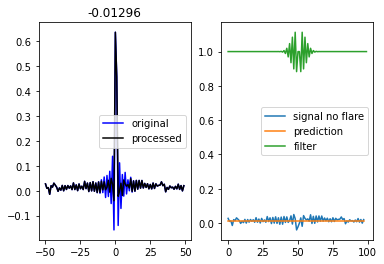

Current filt params: a=0.114, s=3.682, l=2.002, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


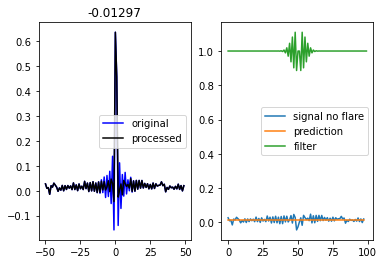

Current filt params: a=0.116, s=3.710, l=2.014, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


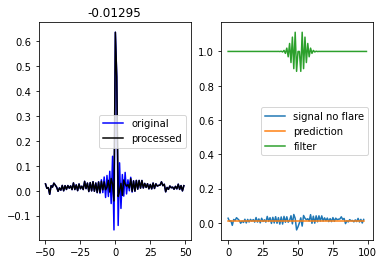

Current filt params: a=0.124, s=3.684, l=1.991, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


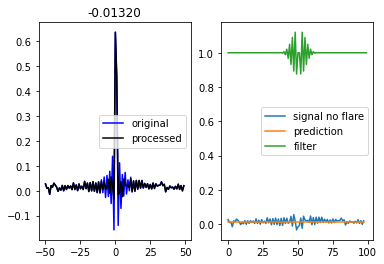

Current filt params: a=0.125, s=3.689, l=2.001, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


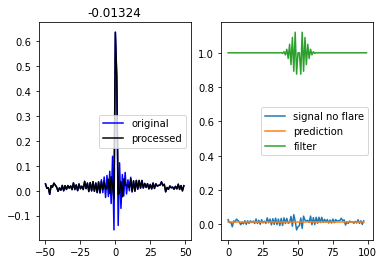

Current filt params: a=0.116, s=3.695, l=1.988, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


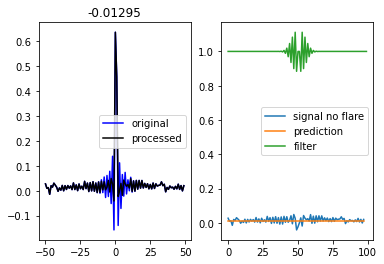

Current filt params: a=0.108, s=3.678, l=1.994, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


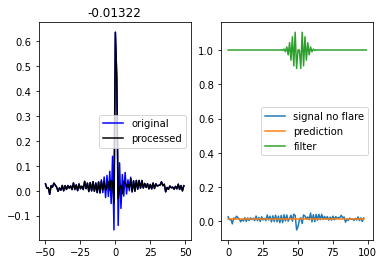

Current filt params: a=0.122, s=3.678, l=1.992, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


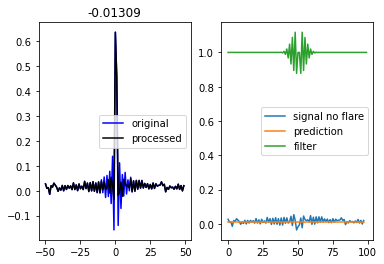

Current filt params: a=0.127, s=3.682, l=2.011, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


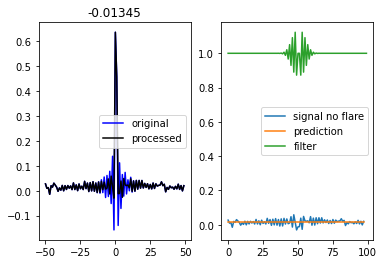

Current filt params: a=0.118, s=3.699, l=1.986, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


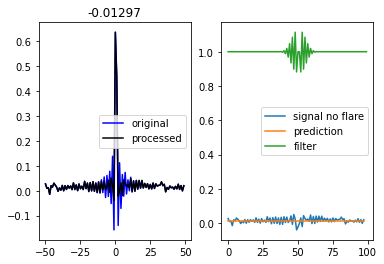

Current filt params: a=0.131, s=3.715, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


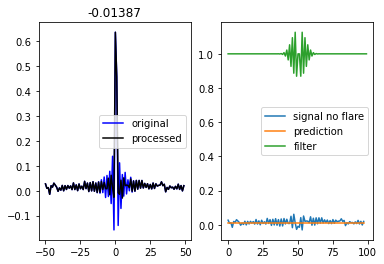

Current filt params: a=0.116, s=3.703, l=2.023, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


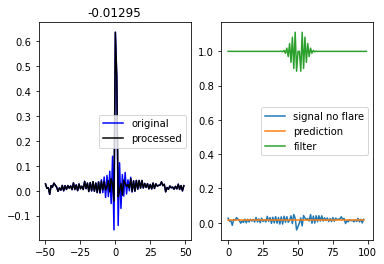

Current filt params: a=0.127, s=3.682, l=1.991, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


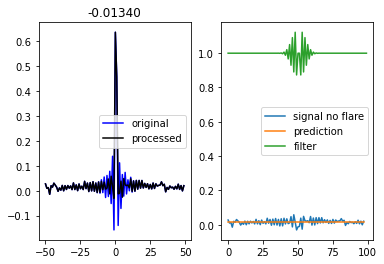

Current filt params: a=0.114, s=3.701, l=2.001, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


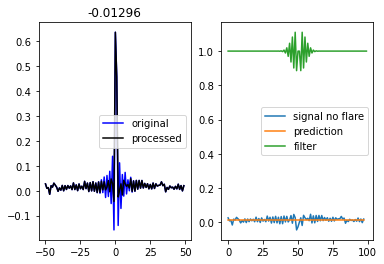

Current filt params: a=0.128, s=3.689, l=2.000, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)


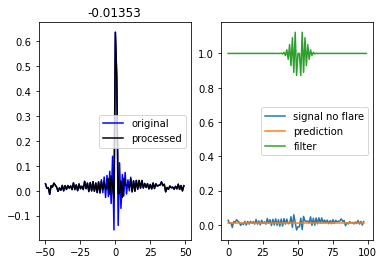

Current filt params: a=0.111, s=3.684, l=2.005, off1=1.000 (rounded to 1), off2=1.000 (rounded to 1)
emcee: Exception while calling your likelihood function:
  params: [0.11062336 3.68406378 2.00531447]
  args: (array([-50., -49., -48., -47., -46., -45., -44., -43., -42., -41., -40.,
       -39., -38., -37., -36., -35., -34., -33., -32., -31., -30., -29.,
       -28., -27., -26., -25., -24., -23., -22., -21., -20., -19., -18.,
       -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,
        -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,
         5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
        27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,
        38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,
        49.]), array([ 2.71201722e-02,  9.51617701e-03,  1.23052508e-02, -1.46162947e-02,
        1.97759280e-02,  1.40152471e-02, 

Traceback (most recent call last):
  File "/Users/Riley/opt/anaconda3/lib/python3.8/site-packages/emcee/ensemble.py", line 619, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-73-0413c2674dbf>", line 73, in log_probability
    return lp + log_likelihood(theta, x, y)
  File "<ipython-input-73-0413c2674dbf>", line 30, in log_likelihood
    plt.show()
  File "/Users/Riley/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py", line 353, in show
    return _backend_mod.show(*args, **kwargs)
  File "/Users/Riley/opt/anaconda3/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py", line 41, in show
    display(
  File "/Users/Riley/opt/anaconda3/lib/python3.8/site-packages/IPython/core/display.py", line 313, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/Users/Riley/opt/anaconda3/lib/python3.8/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "/Users

KeyboardInterrupt: 

In [77]:
# setting plotting=True by hand in the likelihood

LCHAIN = 100
PLOTTINGLOGLIK = True

post_y, gb = gabor_mcmc(bjds[lc], processed[lc], flr, plotting=True)

plt.figure()
plt.plot(gb)
    
    
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x, y, color='k')
ax[1].plot(x, post_y, color='k')

flrtime = 2454833 - time2[flr]

ax[0].set_title('Ringing')
ax[0].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[0].set_ylabel('Standardized Flux')
ax[0].ticklabel_format(useOffset=False, style='plain')


ax[1].set_title('Gabor-Filtered Ringing')
ax[1].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[1].yaxis.tick_right()
ax[1].ticklabel_format(useOffset=False, style='plain')
    
print('Ringing amp as fraction of signal: {}'.format(np.abs(post_y.min()/post_y.max())))

Initialization...
Maximum likelihood estimates:
a = 0.116
s = 3.691
l = 1.996
 
MCMC...
soln5=[0.11573213 3.69076881 1.99633162 1.         1.        ]
128 3


100%|██████████| 1000/1000 [00:23<00:00, 43.01it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Ringing amp as fraction of signal: 0.18048580976091183


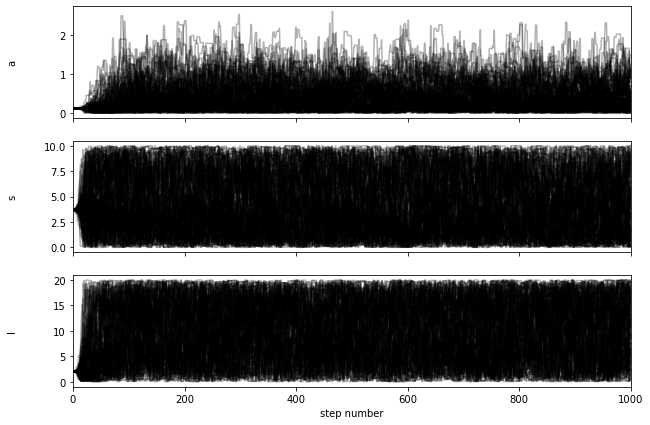

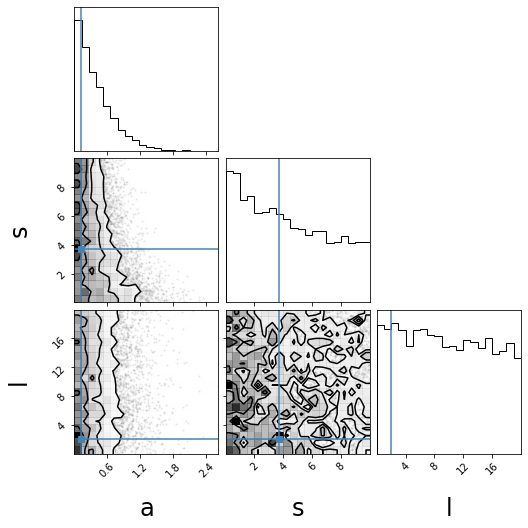

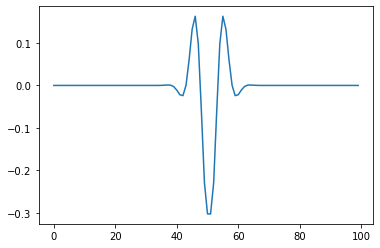

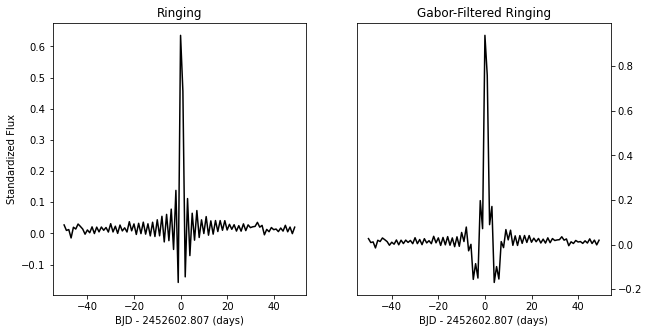

In [83]:
LCHAIN = 1000
PLOTTINGLOGLIK = False

post_y, gb = gabor_mcmc(bjds[lc], processed[lc], flr, plotting=True)

plt.figure()
plt.plot(gb)
    
    
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x, y, color='k')
ax[1].plot(x, post_y, color='k')

flrtime = 2454833 - time2[flr]

ax[0].set_title('Ringing')
ax[0].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[0].set_ylabel('Standardized Flux')
ax[0].ticklabel_format(useOffset=False, style='plain')


ax[1].set_title('Gabor-Filtered Ringing')
ax[1].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[1].yaxis.tick_right()
ax[1].ticklabel_format(useOffset=False, style='plain')
    
print('Ringing amp as fraction of signal: {}'.format(np.abs(post_y.min()/post_y.max())))
    


In [84]:
log_likelihood([0.303,3.946,9.338], x, y)

-0.20465974875044482